### Importing packages

In [4]:
import cv2
import numpy as np
import argparse
from matplotlib import pyplot as plt
import fprmodules.enhancement as fe
import glob
import statistics 
from sklearn.metrics import roc_curve, auc
from scipy.optimize import brentq
from scipy.interpolate import interp1d

In [5]:
# to plot the figures inside the notebook:
%matplotlib inline

### Reading two random images, convert to gray scale and plot

In [6]:
image1_name = "fprdata/DB2_B/108_1.tif"
image2_name = "fprdata/DB2_B/108_4.tif"

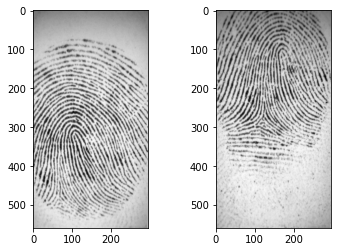

In [7]:
img_1 = cv2.imread(image1_name)
# convert to gray if color
if(len(img_1.shape)>2):
     img_1 = cv2.cvtColor(img_1,cv2.COLOR_BGR2GRAY)

img_2 = cv2.imread(image2_name)
# convert to gray if color
if(len(img_2.shape)>2):
     img_2 = cv2.cvtColor(img_2,cv2.COLOR_BGR2GRAY)
        
#plot        
plt.subplot(1,2,1)
plt.imshow(img_1, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(img_2, cmap='gray')
plt.show()

### Enhancement using ridge orientation and frequency estimation

In [8]:
def imageEnhancement(img):
    # frequency and orientation selective filtering/enhancement
    img_e, mask, orient, freq = fe.image_enhance(img);
    
    # normalize the floating point values to a uint8 range
    img_enhanced = cv2.normalize(img_e, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=0)
    return img_enhanced

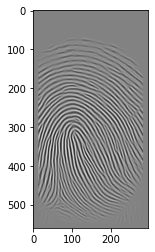

In [9]:
img_e_u_1 = imageEnhancement(img_1)
plt.imshow(img_e_u_1, cmap='gray')

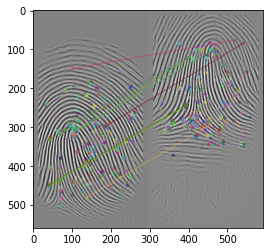

(<matplotlib.image.AxesImage at 0x7fa25211d5c0>, None)

In [10]:
MAX_FEATURES = 500

# Initiate ORB detector
orb = cv2.ORB_create(MAX_FEATURES)

#enhance and normalize images
img_e_u_1 = imageEnhancement(img_1)
img_e_u_2 = imageEnhancement(img_2)

kp1, des1 = orb.detectAndCompute(img_e_u_1,None)
kp2, des2 = orb.detectAndCompute(img_e_u_2,None)


bf = cv2.BFMatcher(cv2.NORM_HAMMING2, crossCheck=True)

matches = bf.match(des1,des2)

# sort matches based on feature distance
# matches = sorted(matches, key=lambda x: x.distance)
matches.sort(key=lambda x: x.distance, reverse=False)

# Draw top 10 matches
imMatches = cv2.drawMatches(img_e_u_1,kp1,img_e_u_2,kp2,matches[:10], None) #, flags=2)

plt.imshow(imMatches),plt.show()

### ORB

In [11]:
def ORBdetector(img1,img2):
    MAX_FEATURES=500
    # Initiate ORB detector
    orb = cv2.ORB_create(MAX_FEATURES)
    
    # find the keypoints and descriptors with ORB    
    kp1, des1 = orb.detectAndCompute(img1,None)
    kp2, des2 = orb.detectAndCompute(img2,None)
    
    #For binary string based descriptors like ORB, BRIEF, BRISK etc, 
    #cv2.NORM_HAMMING should be used, which uses Hamming distance as measurement.
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(des1,des2)
    
    # sort matches based on feature distance
    # matches = sorted(matches, key=lambda x: x.distance)
    matches.sort(key=lambda x: x.distance, reverse=False)
    #print(len(matches))
    
    # Remove not so good matches and keep the average distance of the best matches 
    numGoodMatches = int(len(matches) * 0.25)
    matches = matches[:numGoodMatches]
    
    sum=0
    for m in matches:
        sum+=m.distance     
    if (len(matches) != 0):
        average_distance = sum /len(matches)
    else:
        average_distance = 0.0
    return average_distance

## Evaluate on the Database DB2_B

In [23]:
dataPath="fprdata/DB2_B/*.*"
databaseInitial=(glob.glob(dataPath))
databaseInitial.sort()

In [13]:
# for item in databaseInitial:
#     img = cv2.imread(item)
#     # convert image to gray if color
#     if(len(img.shape)>2):
#         img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
#     img_enhanced = imageEnhancement(img)   
#     cv2.imwrite('fprdata/DB2_B_Enhanced/' + '%s' % (item[-9:]), img_enhanced)

In [14]:
path="fprdata/DB2_B_Enhanced/*.*"
DB2_B_Enhanced=(glob.glob(path))
DB2_B_Enhanced.sort()

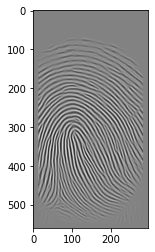

In [15]:
image3 = "fprdata/DB2_B_Enhanced/108_1.tif"

img_3 = cv2.imread(image3)
# convert to gray if color
if(len(img_3.shape)>2):
     img_3 = cv2.cvtColor(img_3,cv2.COLOR_BGR2GRAY)

plt.imshow(img_3,cmap='gray')
plt.show()

In [16]:
#Create a method that normalizes data between 0 and 1.
def normalization(arr):
    xmax, xmin = arr.max(), arr.min()
    normalized = (arr - xmin)/(xmax - xmin)
    return normalized

In [17]:
def distancesArray(db, algorithm):
    arr=np.zeros((80,80)) 
    for i in range(len(db)):
        img1 = cv2.imread(db[i])
        for j in range(len(db)):
            img2=cv2.imread(db[j])
            arr[i,j] = algorithm(img1,img2)
    return arr

In [18]:
#Create a matrix containing the true labels for the total distances case. 
distance_labels=np.ones((80,80), dtype=int)

ck=0
counter=0
for i in range(0,80):
    for j in range(0+ck,8+ck):
        distance_labels[i,j] = 0
    counter+=1
    if counter==8:
        ck+=8
        counter=0
#print(distance_labels)
#print(np.shape(distance_labels))

In [20]:
ORB_AverageDistances_DB2_B = distancesArray(DB2_B_Enhanced, ORBdetector)

In [21]:
ORB_AverageDistances_DB2_B_normalized=normalization(ORB_AverageDistances_DB2_B)

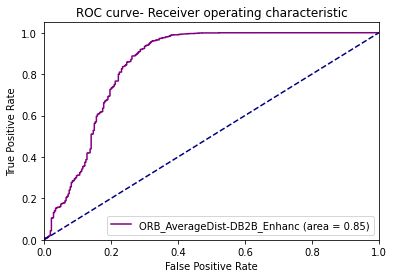

In [22]:
from sklearn.metrics import roc_curve, auc
from scipy.optimize import brentq
from scipy.interpolate import interp1d

fpr5, tpr5, thresholds5 = roc_curve(distance_labels.flatten(), ORB_AverageDistances_DB2_B_normalized.flatten())

roc_auc5 = auc(fpr5, tpr5)

plt.figure()
plt.plot(fpr5, tpr5, color='purple', label='ORB_AverageDist-DB2B_Enhanc (area = %0.2f)' % roc_auc5)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve- Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()